In [30]:
#Import Libraries
from ciao_contrib.runtool import *
from ciao_contrib.runtool import dmstat, dmextract
import subprocess
import re
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits

In [31]:
#Define the major path to working directory
binning = int(input("Enter the bin size: "))
obsid = input("Enter the Observation ID: ")
path = f"/Volumes/Storage/Chandra/M33_file/{obsid}"

In [32]:
#Finds the name of the FITS file, and then defines more directories
pattern = r"^acis.*\.fits$"
pattern2 = r"^hrc.*\.fits$"

for file in os.listdir(path):
    if re.match(pattern, file) or re.match(pattern2, file):
        final = file

final_path = f'/Volumes/Storage/Chandra/M33_file/{obsid}/{final}'
region_path = f'{path}/src.reg'
bkg_path = f'{path}/bkg.reg'


In [33]:
#Converts DMSTAT info for src.reg into a Pandas DataFrame
subprocess.run(['punlearn', 'dmstat'], shell=True, executable='/bin/bash')
cmd = f'dmstat "{final_path}[sky=region({region_path})][cols ccd_id]"'
dmstat_result = subprocess.run(cmd, shell=True, executable='/bin/bash', capture_output=True, text=True)
output = dmstat_result.stdout

stats = {}
for line in output.split('\n'):
    if "min:" in line:
        stats['min'] = float(line.split()[1])
    elif "max:" in line:
        stats['max'] = float(line.split()[1])
    elif "mean:" in line:
        stats['mean'] = float(line.split()[1])
    elif "sigma:" in line:
        stats['sigma'] = float(line.split()[1])
    elif "sum:" in line:
        stats['sum'] = float(line.split()[1])
    elif "good:" in line:
        stats['good'] = int(line.split()[1])
    elif "null:" in line:
        stats['null'] = int(line.split()[1])

df = pd.DataFrame([stats])

plist: no paramfiles to unlearn


In [34]:
#Converts DMSTAT info for bkg.reg into a Pandas DataFrame
subprocess.run(['punlearn', 'dmstat'], shell=True, executable='/bin/bash')
cmd = f'dmstat "{final_path}[sky=region({bkg_path})][cols ccd_id]"'
dmstat_result = subprocess.run(cmd, shell=True, executable='/bin/bash', capture_output=True, text=True)
output = dmstat_result.stdout

stats = {}
for line in output.split('\n'):
    if "min:" in line:
        stats['min'] = float(line.split()[1])
    elif "max:" in line:
        stats['max'] = float(line.split()[1])
    elif "mean:" in line:
        stats['mean'] = float(line.split()[1])
    elif "sigma:" in line:
        stats['sigma'] = float(line.split()[1])
    elif "sum:" in line:
        stats['sum'] = float(line.split()[1])
    elif "good:" in line:
        stats['good'] = int(line.split()[1])
    elif "null:" in line:
        stats['null'] = int(line.split()[1])

df1 = pd.DataFrame([stats])

plist: no paramfiles to unlearn


In [35]:
#Stores the ccd_ids for the source and the backgrounds
src_ccdid = int(df["min"][0])
bkg_ccdid = int(df1['min'][0])

In [36]:
#Uses DMEXTRACT to creat a background subtracted light curve, stored as sub_lc.fits
dmextract.punlearn()
dmextract(infile=f"{final_path}[ccd_id={src_ccdid}, sky=region({region_path})][bin time=::{binning}]", opt = "ltc1", bkg=f"{final_path}[ccd_id={bkg_ccdid}, sky=region({bkg_path})]", outfile=f"{path}/sub_lc.fits")

In [37]:
#Figures out galaxy name from path, and converts sub_lc.fits into sub_lc.fits.txt for plotting
pattern = r'[^/]+(?=_file)'
match = re.search(pattern, path)
file = f"{path}/sub_lc.fits"

galaxy = match.group(0)

hdulist = fits.open(file)
cols = ["TIME_BIN", "TIME_MIN", "TIME", "TIME_MAX", "COUNTS", "STAT_ERR", "AREA", "EXPOSURE", "COUNT_RATE", "COUNT_RATE_ERR", "BG_AREA", "BG_ERR", "BG_RATE", "NORM_BG_COUNTS", "NORM_BG_ERR", "NET_COUNTS", "NET_ERR", "NET_RATE", "ERR_RATE"]

dataframe = pd.DataFrame(hdulist[1].data)
dataframe = dataframe[cols]

hdulist.close()
dataframe.to_csv(f"{path}/sub_lc.fits.txt", index = None, sep = ",")

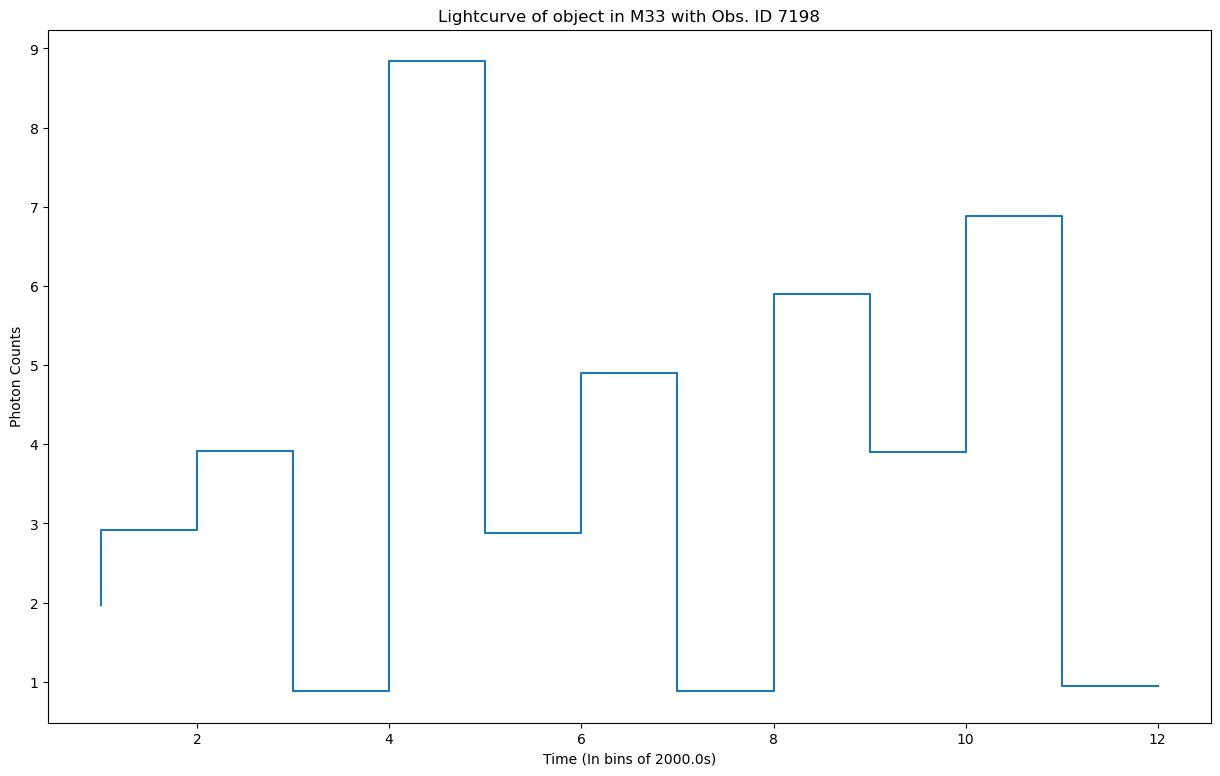

In [38]:
#Plots the background subtracted light curve
df3 = pd.read_csv(f"{file}.txt")
plt.figure(figsize=(15, 9))
plt.step(df3["TIME_BIN"], df3["NET_COUNTS"])
plt.xlabel(f"Time (In bins of {binning}.0s)")
plt.ylabel("Photon Counts")
plt.title(f"Lightcurve of object in {galaxy} with Obs. ID {obsid}")
plt.show()